In [1]:
import kaggle

In [1]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import timm
from fastai.vision.all import *
from fastai.imports import *

# Creating dataloader

In [3]:
arch = "resnet50"
path = Path('/nfs/home/912c2e22633dde2e/RSNA-Screening-Mammography-Patch-Heatmap-Classifier/patches_dst/ratio0.5_patches10_256x')
files = get_image_files(path)

set_seed(123)

In [4]:
ptidx_unique = np.unique(np.array([str(x).split("/")[-2] for x in files]))
valid = np.random.choice(ptidx_unique, size=int(len(ptidx_unique)*0.15), replace=False)

splitter = FuncSplitter(lambda o: str(o).split(os.path.sep)[-2] in valid)

aug_transforms = [Dihedral(p=1.0), Contrast(0.1), Brightness(0.1), Zoom(), Warp(magnitude=0.1)]

cbs = [EarlyStoppingCallback(min_delta=0.001, patience=4)]

loss_func = LabelSmoothingCrossEntropy()
metrics = [error_rate, RocAuc()]

In [5]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=splitter,
                 get_y=using_attr(RegexLabeller(r'([A-Z]+)'), 'name'),
                 batch_tfms=[*aug_transforms, Normalize.from_stats(*imagenet_stats)],
               ).dataloaders(path, bs=64, shuffle=True)

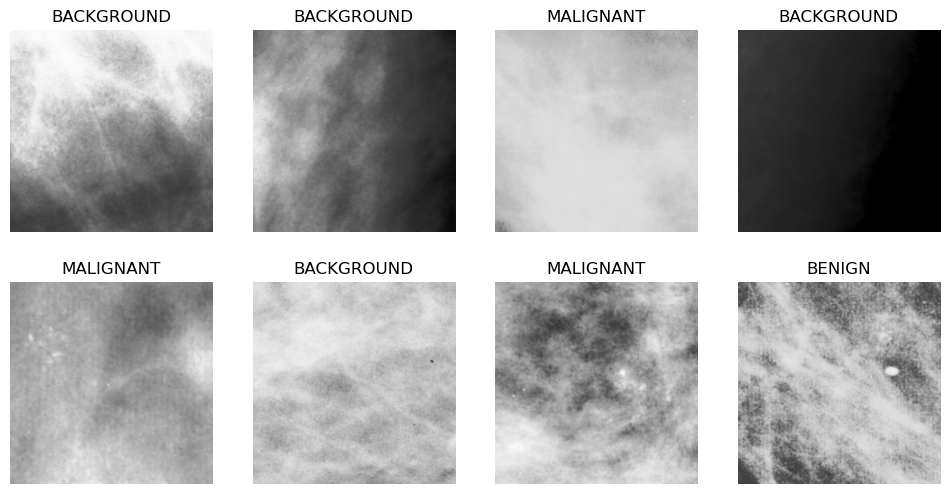

In [6]:
dls.show_batch(max_n=8)

# Resnet50

In [12]:
learn = vision_learner(dls, arch, metrics=metrics, loss_func=loss_func).to_fp16()

SuggestedLRs(valley=0.00013182566908653826)

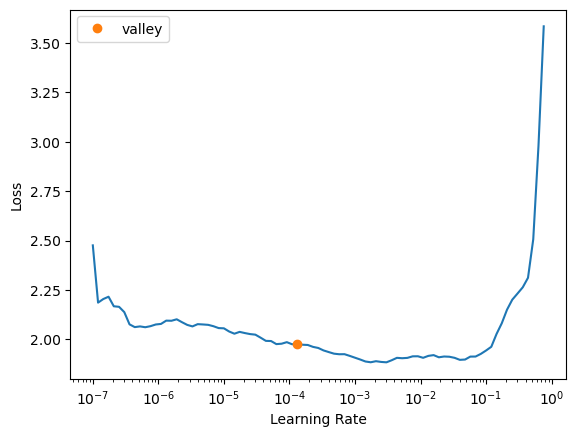

In [13]:
learn.lr_find()

In [15]:
learn.fit(100, slice(1e-2), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="rs50_redlrplat_1"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-6)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.149817,1.132339,0.498355,0.691131,01:34
1,1.038735,0.986308,0.459598,0.718068,01:34
2,0.979721,0.974642,0.470567,0.736150,01:34
3,0.957701,0.990504,0.463254,0.730423,01:34
4,0.947521,1.407917,0.456307,0.731359,01:34
5,0.928635,1.519274,0.453748,0.747545,01:35
6,0.923114,1.141903,0.446435,0.748146,01:35


Better model found at epoch 0 with valid_loss value: 1.1323387622833252.
Better model found at epoch 1 with valid_loss value: 0.9863083958625793.
Better model found at epoch 2 with valid_loss value: 0.9746421575546265.
Epoch 4: reducing lr to 0.001
Epoch 6: reducing lr to 0.0001
No improvement since epoch 2: early stopping


In [16]:
learn.load("rs50_redlrplat_1")
learn.unfreeze()

learn.fit(100, slice(2.5e-5, 2.5e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="rs50_redlrplat_2"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-8)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.955398,0.975635,0.467276,0.734065,01:57
1,0.934026,1.016315,0.477148,0.718125,01:57
2,0.921167,0.999493,0.457404,0.737431,01:58
3,0.918636,0.937725,0.429616,0.760129,01:57
4,0.926602,0.943853,0.445704,0.754735,01:58
5,0.913712,0.941472,0.436197,0.754286,01:58
6,0.913552,0.942594,0.435466,0.753150,01:58
7,0.903026,0.947101,0.441316,0.752237,01:58


Better model found at epoch 0 with valid_loss value: 0.9756350517272949.
Epoch 2: reducing lr to 0.00025
Better model found at epoch 3 with valid_loss value: 0.9377245903015137.
Epoch 5: reducing lr to 2.5e-05
Epoch 7: reducing lr to 2.5e-06
No improvement since epoch 3: early stopping


# xresnet18

In [18]:
arch = xresnet18(pretrained=True, n_out=3)

In [20]:
learn = Learner(dls, model=arch, metrics=metrics, loss_func=loss_func).to_fp16()

SuggestedLRs(valley=0.00015848931798245758)

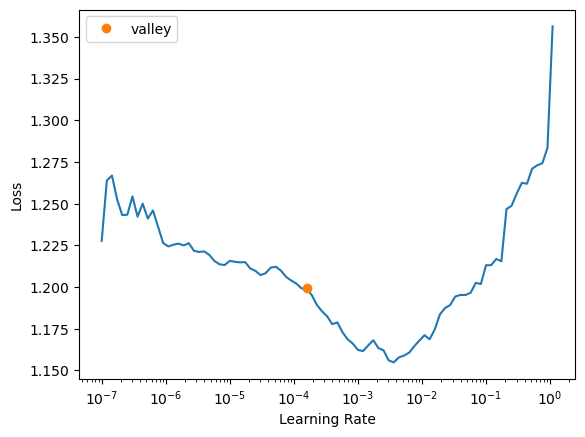

In [21]:
learn.lr_find()

In [22]:
learn.fit(100, slice(5e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="xrs18_redlrplat_1"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-6)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.049235,1.076677,0.560878,0.650910,01:02
1,1.042949,1.278779,0.647898,0.586196,01:02
2,1.023339,1.061655,0.563437,0.658574,01:02
3,1.012260,1.012780,0.506033,0.693044,01:02
4,0.984694,0.992890,0.485192,0.704378,01:02
5,0.970412,0.991161,0.487386,0.705937,01:02
6,0.958334,0.999283,0.543327,0.701207,01:02
7,0.912954,0.916845,0.465814,0.757762,01:02
8,0.905165,0.920187,0.463985,0.753400,01:02
9,0.900753,0.916758,0.458135,0.757714,01:02


Better model found at epoch 0 with valid_loss value: 1.0766772031784058.
Better model found at epoch 2 with valid_loss value: 1.0616549253463745.
Better model found at epoch 3 with valid_loss value: 1.012779712677002.
Better model found at epoch 4 with valid_loss value: 0.9928901791572571.
Better model found at epoch 5 with valid_loss value: 0.9911614060401917.
Epoch 6: reducing lr to 0.0005
Better model found at epoch 7 with valid_loss value: 0.9168447256088257.
Better model found at epoch 9 with valid_loss value: 0.9167584180831909.
Epoch 9: reducing lr to 5e-05
Better model found at epoch 10 with valid_loss value: 0.9048427939414978.
Better model found at epoch 11 with valid_loss value: 0.9032485485076904.
Better model found at epoch 12 with valid_loss value: 0.9018009901046753.
Epoch 12: reducing lr to 5e-06
Better model found at epoch 13 with valid_loss value: 0.9013805985450745.
Epoch 14: reducing lr to 1e-06
No improvement since epoch 12: early stopping


In [24]:
learn.load("xrs18_redlrplat_1")
learn.unfreeze()

learn.fit(100, slice(1e-5, 1e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="xrs18_redlrplat_2"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-8)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.901527,0.931039,0.478245,0.744793,01:02
1,0.883765,0.902477,0.451554,0.766863,01:02
2,0.876603,0.897486,0.441316,0.771710,01:02
3,0.878264,0.900882,0.436197,0.773842,01:02
4,0.863531,0.889757,0.423400,0.778676,01:01
5,0.860550,0.888838,0.419378,0.779343,01:02
6,0.853356,0.889231,0.422669,0.778028,01:02
7,0.848305,0.888524,0.420841,0.778890,01:02
8,0.855034,0.888918,0.423035,0.779099,01:03
9,0.853608,0.888297,0.422303,0.779301,01:02


Better model found at epoch 0 with valid_loss value: 0.9310387969017029.
Better model found at epoch 1 with valid_loss value: 0.9024768471717834.
Better model found at epoch 2 with valid_loss value: 0.8974860906600952.
Epoch 3: reducing lr to 0.0001
Better model found at epoch 4 with valid_loss value: 0.8897574543952942.
Better model found at epoch 5 with valid_loss value: 0.888837993144989.
Epoch 6: reducing lr to 1e-05
Better model found at epoch 7 with valid_loss value: 0.888524055480957.
Epoch 8: reducing lr to 1.0000000000000002e-06
Better model found at epoch 9 with valid_loss value: 0.8882972002029419.
Epoch 10: reducing lr to 1.0000000000000002e-07
No improvement since epoch 7: early stopping


# Resnet34

In [25]:
arch="resnet34"

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /home/912c2e22633dde2e/.cache/torch/hub/checkpoints/resnet34-43635321.pth


SuggestedLRs(valley=0.00363078061491251)

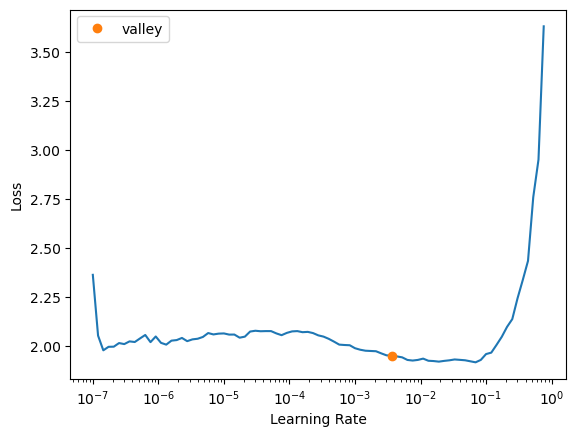

In [26]:
learn = vision_learner(dls, arch, metrics=metrics, loss_func=loss_func).to_fp16()
learn.lr_find()

In [27]:
learn.fit(100, slice(5e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="rs34_redlrplat_1"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-6)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.120352,1.072157,0.514077,0.660632,00:56
1,1.057481,1.024840,0.484461,0.698622,00:55
2,1.015756,1.006526,0.503474,0.701359,00:54
3,0.980401,0.974932,0.491042,0.719052,00:54
4,0.958485,0.978750,0.480073,0.719406,00:55
5,0.946984,0.960997,0.459232,0.737534,00:55
6,0.929619,0.934268,0.450457,0.754429,00:54
7,0.917185,0.929121,0.432176,0.760964,00:55
8,0.908468,0.926272,0.428885,0.768674,00:55
9,0.886443,0.914985,0.423400,0.772533,00:54


Better model found at epoch 0 with valid_loss value: 1.0721570253372192.
Better model found at epoch 1 with valid_loss value: 1.0248396396636963.
Better model found at epoch 2 with valid_loss value: 1.0065256357192993.
Better model found at epoch 3 with valid_loss value: 0.9749322533607483.
Better model found at epoch 5 with valid_loss value: 0.9609969258308411.
Better model found at epoch 6 with valid_loss value: 0.934267520904541.
Better model found at epoch 7 with valid_loss value: 0.9291207790374756.
Better model found at epoch 8 with valid_loss value: 0.9262716770172119.
Epoch 8: reducing lr to 0.0005
Better model found at epoch 9 with valid_loss value: 0.9149848818778992.
Better model found at epoch 10 with valid_loss value: 0.9143400192260742.
Epoch 11: reducing lr to 5e-05
Better model found at epoch 13 with valid_loss value: 0.9126118421554565.
Epoch 13: reducing lr to 5e-06
Epoch 15: reducing lr to 1e-06
No improvement since epoch 13: early stopping


In [28]:
learn.load("rs34_redlrplat_1")
learn.unfreeze()

learn.fit(100, slice(1e-5, 1e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="rs34_redlrplat_2"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-8)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.870561,0.900613,0.408410,0.786267,01:09
1,0.843693,0.887074,0.396344,0.793370,01:10
2,0.830988,0.892623,0.386837,0.795873,01:10
3,0.814698,0.884638,0.373309,0.804498,01:10
4,0.800114,0.886863,0.384644,0.801629,01:09
5,0.787356,0.883814,0.378062,0.802996,01:09
6,0.796124,0.887435,0.371115,0.805749,01:10
7,0.798830,0.886605,0.375868,0.804262,01:10


Better model found at epoch 0 with valid_loss value: 0.9006134271621704.
Better model found at epoch 1 with valid_loss value: 0.8870742917060852.
Better model found at epoch 3 with valid_loss value: 0.884638249874115.
Epoch 3: reducing lr to 0.0001
Better model found at epoch 5 with valid_loss value: 0.8838140368461609.
Epoch 5: reducing lr to 1e-05
Epoch 7: reducing lr to 1.0000000000000002e-06
No improvement since epoch 3: early stopping


# EfficientNetv2 small

In [48]:
[x for x in timm.list_models() if "efficient" in x]

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl',
 'gc_efficientnet

In [10]:
arch="tf_efficientnetv2_s"

In [11]:
learn = vision_learner(dls, arch, metrics=metrics, loss_func=loss_func).to_fp16()
#learn.lr_find()

In [50]:
learn.fit(100, slice(5e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="effnetv2_1"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-6)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.090247,1.070543,0.518099,0.665258,03:09
1,1.035266,0.998210,0.469835,0.723024,03:10
2,0.979692,0.960618,0.442413,0.745164,03:10
3,0.945784,0.941171,0.417916,0.762990,03:10
4,0.903214,0.938693,0.421207,0.767770,03:11
5,0.875952,0.914119,0.390128,0.784361,03:12
6,0.861559,0.902905,0.393053,0.790335,03:11
7,0.845614,0.894659,0.378062,0.797475,03:12
8,0.835746,0.887304,0.374406,0.804527,03:10
9,0.819773,0.889461,0.372943,0.812736,03:10


Better model found at epoch 0 with valid_loss value: 1.070542573928833.
Better model found at epoch 1 with valid_loss value: 0.9982097148895264.
Better model found at epoch 2 with valid_loss value: 0.9606179594993591.
Better model found at epoch 3 with valid_loss value: 0.9411706924438477.
Better model found at epoch 4 with valid_loss value: 0.938693106174469.
Better model found at epoch 5 with valid_loss value: 0.9141188859939575.
Better model found at epoch 6 with valid_loss value: 0.9029048085212708.
Better model found at epoch 7 with valid_loss value: 0.8946585655212402.
Better model found at epoch 8 with valid_loss value: 0.8873041272163391.
Better model found at epoch 10 with valid_loss value: 0.8855209946632385.
Epoch 10: reducing lr to 0.0005
Better model found at epoch 11 with valid_loss value: 0.8746234774589539.
Epoch 13: reducing lr to 5e-05


In [12]:
learn.load("effnetv2_1")
learn.unfreeze()

learn.fit(100, slice(2.5e-5, 2.5e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="effnetv2_2"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-8)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.749413,0.869587,0.374406,0.816473,04:08
1,0.705640,0.869990,0.353199,0.826945,04:09
2,0.668785,0.873492,0.358318,0.825993,04:09
3,0.648153,0.881229,0.356124,0.823026,04:10
4,0.650571,0.883814,0.355027,0.826206,04:09


Better model found at epoch 0 with valid_loss value: 0.869586706161499.
Epoch 2: reducing lr to 0.00025
Epoch 4: reducing lr to 2.5e-05
No improvement since epoch 0: early stopping


# Resnet26

In [10]:
arch="resnet26"

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26-9aa10e23.pth" to /home/912c2e22633dde2e/.cache/torch/hub/checkpoints/resnet26-9aa10e23.pth


SuggestedLRs(valley=0.00363078061491251)

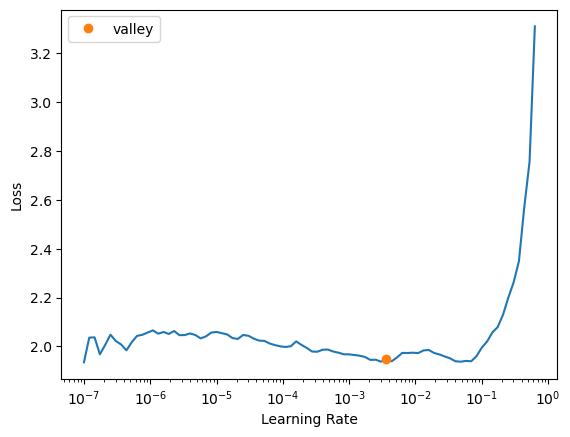

In [11]:
learn = vision_learner(dls, arch, metrics=metrics, loss_func=loss_func).to_fp16()
learn.lr_find()

In [12]:
learn.fit(100, slice(5e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="resnet26_1"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-6)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.060727,1.035889,0.489945,0.725390,01:07
1,1.007332,0.971527,0.455576,0.741741,01:06
2,0.981700,0.963555,0.453016,0.743903,01:07
3,0.953084,0.963866,0.450823,0.739834,01:07
4,0.907403,0.931284,0.428519,0.763821,01:07
5,0.894928,0.917565,0.415356,0.771219,01:07
6,0.890876,0.920886,0.412797,0.771411,01:07
7,0.876712,0.916950,0.408044,0.772832,01:06
8,0.886816,0.916515,0.409506,0.774642,01:07
9,0.881719,0.916800,0.415722,0.774132,01:07


Better model found at epoch 0 with valid_loss value: 1.0358887910842896.
Better model found at epoch 1 with valid_loss value: 0.9715269804000854.
Better model found at epoch 2 with valid_loss value: 0.9635547399520874.
Epoch 3: reducing lr to 0.0005
Better model found at epoch 4 with valid_loss value: 0.9312837719917297.
Better model found at epoch 5 with valid_loss value: 0.9175645709037781.
Better model found at epoch 7 with valid_loss value: 0.9169501662254333.
Epoch 7: reducing lr to 5e-05
Better model found at epoch 8 with valid_loss value: 0.9165152311325073.
Epoch 9: reducing lr to 5e-06
Better model found at epoch 10 with valid_loss value: 0.9158771634101868.
Better model found at epoch 11 with valid_loss value: 0.9158030152320862.
Epoch 11: reducing lr to 1e-06
No improvement since epoch 8: early stopping


In [13]:
learn.load("resnet26_1")
learn.unfreeze()

learn.fit(100, slice(1e-5, 1e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="resnet26_2"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-8)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.861994,0.916165,0.414625,0.781370,01:22
1,0.858704,0.901841,0.400366,0.785583,01:22
2,0.823800,0.901465,0.386106,0.795563,01:22
3,0.816039,0.900300,0.386106,0.794803,01:23
4,0.792082,0.897535,0.382084,0.796636,01:21
5,0.785453,0.897698,0.377697,0.797020,01:22
6,0.788029,0.899908,0.382450,0.794951,01:22
7,0.791918,0.898411,0.380987,0.797458,01:21
8,0.785141,0.899721,0.378062,0.795703,01:22


Better model found at epoch 0 with valid_loss value: 0.9161648154258728.
Better model found at epoch 1 with valid_loss value: 0.9018411040306091.
Better model found at epoch 2 with valid_loss value: 0.9014652967453003.
Better model found at epoch 3 with valid_loss value: 0.9003000855445862.
Epoch 3: reducing lr to 0.0001
Better model found at epoch 4 with valid_loss value: 0.8975350260734558.
Epoch 5: reducing lr to 1e-05
Epoch 7: reducing lr to 1.0000000000000002e-06
No improvement since epoch 4: early stopping
